# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Define some optimization parameters 

In [4]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/')#, mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False
is_display = True
is_optimization = False 
is_optimization_psf = True
is_flip = False

# data files for parameters and measuremets 
matlab_val_file = './Data/DROPLETS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,-.5,-.5,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .075 # refractive index of the object (difference)

'''Define Optimization Parameters'''
my_learningrate = 1e-2  # learning rate
lambda_tv = 0#1e-4 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 00

Niter = 1000
Ndisplay = 10


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

Folder exists already


# Generate Test-Object

In [5]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)

if(is_flip):
    np_meas = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas = matlab_val
print('do we need to flip the data?! -> Observe FFT!!')


''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=0
muscat.shiftIcX=0
muscat.dn = dn
#muscat.NAc =.4
muscat.dz = muscat.lambda0/4
print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors

do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!
Attention: Changed Z-sampling!!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [6]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True)

----------> Be aware: We are taking aberrations into account!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 49


# Generate Computational Graph (fwd model)

Buildup Q-PHASE Model 


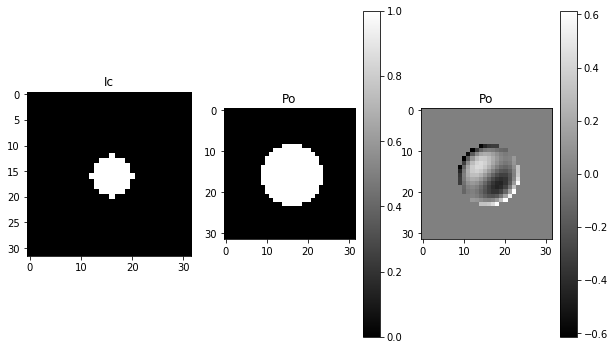

In [7]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


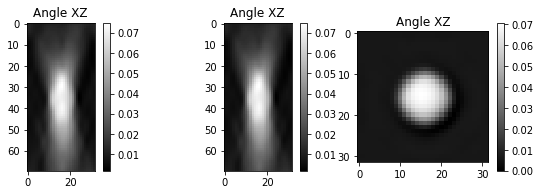

In [8]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas#*np.exp(1j*np.pi)
if(True):
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess/np.max(init_guess)*muscat.dn
else:
    init_guess = np.ones(np_meas.shape)*muscat.dn
    
if(is_display): plt.subplot(231), plt.title('Angle XZ'),plt.imshow(init_guess[:,muscat.mysize[1]//2,:]), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(init_guess[:,:,muscat.mysize[1]//2]), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(init_guess[muscat.mysize[0]//2,:,:]), plt.colorbar(),plt.show()


# Optimize

Regularizer: Penalize Values less then 0
Regularizer: Penalize Values higher then 0.2


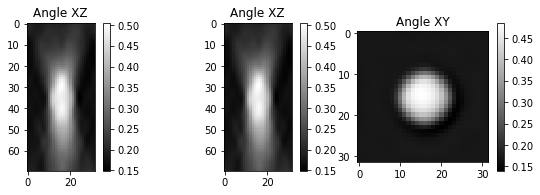

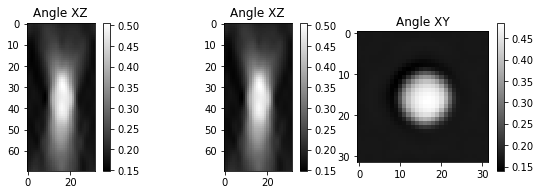

Variable:  Variable_assignment/Variable:0
Shape:  (9,)
[ 0.   0.   0.   0.   0.   0.  -0.5 -0.5  0. ]
Variable:  Variable:0
Shape:  ()
1
Variable:  Variable_1:0
Shape:  ()
0.0


In [9]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=muscat.mysize)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj)  #Alernatively total_variation
tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj, minval=0)
tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj, maxval=.2) 
tf_globalphase = tf.Variable(0., tf.float32) # tf.exp(1j*tf.cast(tf_globalphase, tf.complex64)
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_fwd  - (tf_meas))) # allow a global phase parameter to avoid unwrapping effects
tf_loss = tf_fidelity +  tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
if(True):          
    '''Define Optimizer'''
    tf_optimizer = tf.train.AdamOptimizer(my_learningrate)
    tf_lossop = tf_optimizer.minimize(tf_loss)
else:
    tf_optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': 40},method='L-BFGS-B') # 'L-BFGS-B'
    tf_optimizer.minimize(sess)
    myloss=loss.eval()
    
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_optimization:
    sess.run(tf.assign(muscat.TF_obj, init_guess)); # assign abs of measurement as initial guess of 
my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape

if(is_display): plt.subplot(231), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas*np.exp(1j*np.pi))[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas*np.exp(1j*np.pi))[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY'),plt.imshow(np.angle(np_meas*np.exp(1j*np.pi))[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(my_fwd*np.exp(1j*np.pi))[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(my_fwd*np.exp(1j*np.pi))[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(my_fwd*np.exp(1j*np.pi))[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

    
variables_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variables_names)
for k, v in zip(variables_names, values):
    print("Variable: ", k)
    print("Shape: ", v.shape)
    print(v    )

In [10]:
#%%
''' Optimize the model '''
print('Start optimizing')
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
resultlist = []
globalphaselist = []
np_meas = matlab_val # use the previously simulated data

for iterx in range(1,Niter):
    # try to optimize
    
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_opt, my_res, my_loss, my_fidelity, my_negloss, my_posloss, my_tvloss, myglobalphase =  \
            sess.run([tf_lossop, muscat.TF_obj, tf_loss, tf_fidelity, tf_negloss, tf_posloss, tf_tvloss, tf_globalphase], feed_dict={tf_meas:np_meas})


            
        print('MY loss: @'+str(iterx)+': ' + str(my_loss) + ' - Fidelity: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', Pos: '+str(my_posloss)+', TV: '+str(my_tvloss))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myposlosslist.append(my_negloss)
        myneglosslist.append(my_posloss)
        mytvlosslist.append(my_tvloss)
        resultlist.append(my_res)
        globalphaselist.append(myglobalphase)
    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas})
        #plt.imshow(np.abs(my_res[:,50,:]))
        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

Start optimizing
MY loss: @10: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @20: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @30: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @40: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @50: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @60: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @70: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @80: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @90: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @100: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @110: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @120: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @130: 8.997945 - Fidelity: 8.997945, Neg: 0.0, Pos: 0.0, TV: 0.0
MY loss: @140: 8.997945 - Fide

# Display result - FFT

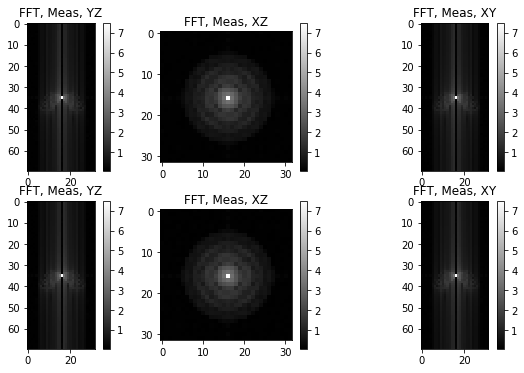

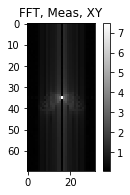

Assuming first axis is time


In [11]:
#%% Display the results
is_display=True
myfwd, mymeas, my_res = sess.run([tf_fwd, tf_meas, muscat.TF_obj], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    


#%% save the results
#np.save(savepath+'/rec.npy', my_res)
import src.data as data
data.export_realdatastack_h5('temp.h5', 'temp', np.array(resultlist))


# Display results ABS/Angle - FWD model

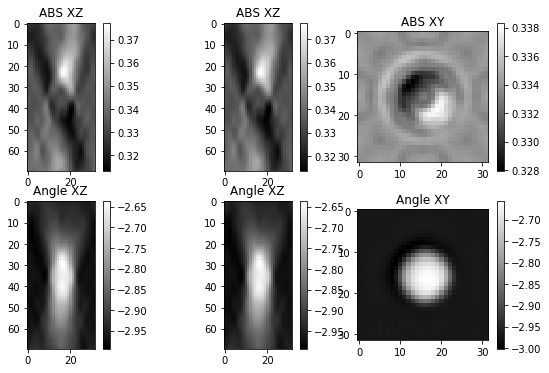

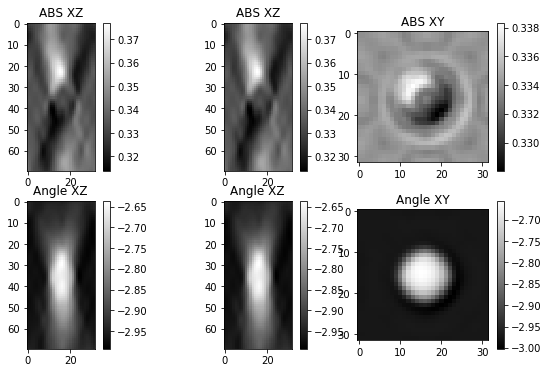

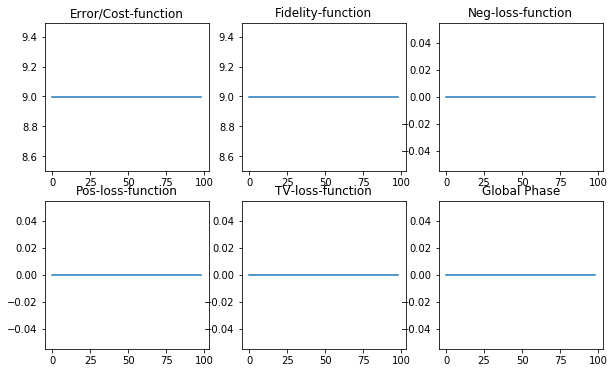

(<matplotlib.axes._subplots.AxesSubplot at 0x1b36c566748>,
 Text(0.5,1,'Global Phase'),
 None)

In [17]:

if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()

    
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()

# diplay the error over time
plt.subplot(231), plt.title('Error/Cost-function'), plt.plot(np.array(mylosslist))
plt.subplot(232), plt.title('Fidelity-function'), plt.plot(np.array(myfidelitylist))
plt.subplot(233), plt.title('Neg-loss-function'), plt.plot(np.array(myposlosslist))
plt.subplot(234), plt.title('Pos-loss-function'), plt.plot(np.array(myneglosslist))
plt.subplot(235), plt.title('TV-loss-function'), plt.plot(np.array(mytvlosslist))
plt.subplot(236), plt.title('Global Phase'), plt.plot(np.array(globalphaselist)), plt.show()



# Display Result Refractive index

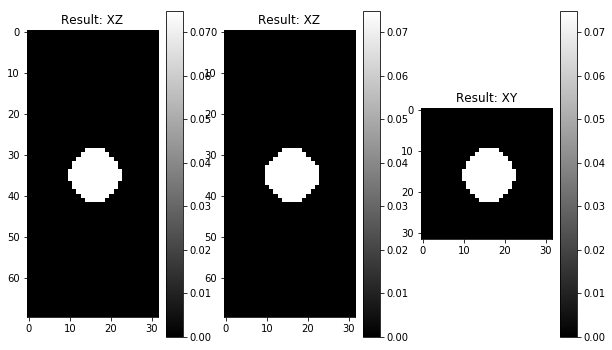

In [13]:
if(False):
    my_residual = tf_helper.abssqr(myfwd-mymeas)
    if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
    if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
    if(is_display): plt.title('Residual: XY'),plt.imshow(my_residual [muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


if(is_display): plt.subplot(131), plt.title('Result: XZ'),plt.imshow(my_res[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(132), plt.title('Result: XZ'),plt.imshow(my_res[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(133), plt.title('Result: XY'),plt.imshow(my_res[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


In [14]:
# Display recovered pupil

[ 0.   0.   0.   0.   0.   0.  -0.5 -0.5  0. ]


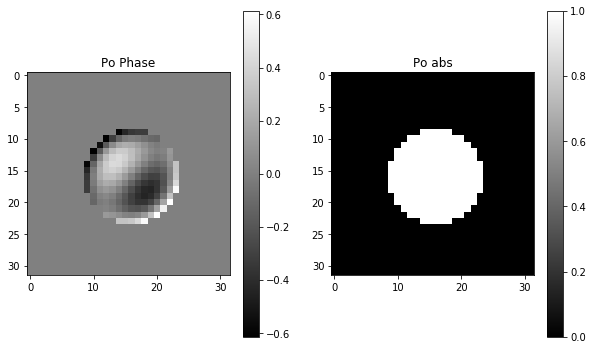

Assuming first axis is time


In [15]:
#plt.subplot(121), plt.imshow(np.angle(sess.run(muscat.TF_Po.eval)))
print(np.real(sess.run(muscat.TF_zernikefactors)))
plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar(), plt.show()

np.save('tmp.npy',np.array(resultlist))
data.export_realdatastack_h5('temp.h5', 'temp', np.array(resultlist))

# Save results

# %% save the results
np.save(savepath+'/rec.npy', my_res)
data.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
data.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
data.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')